**БОЛЬШОЙ ДИСКЛЕЙМЕР**  
Потому что Word2Vec [очень прикольный](https://stackoverflow.com/questions/61730650/why-do-my-similarity-values-change-after-each-running-with-pretrained-embedding),при каждом перебучении моделька дает разные результаты. Поэтому используйте пожалуйста turg.bin, прикрепленный к дз, чтобы все комментарии были осмысленными :3 (переписывать всё ещё раз все я не готова.)

### Импорт

In [ ]:
# !pip install nltk
# !pip install gensim
# !pip install pymorphy3 --q
# !pip install wikipedia
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn 

In [ ]:
import csv

import zipfile

import gensim
import urllib.request

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')  
nltk.download('punkt')
nltk.download('punkt_tab')

sw = stopwords.words('russian')
tokenizer = RegexpTokenizer(r'\w+')

from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()


from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

import wikipedia as wiki

import time

import numpy as np

import seaborn as sns



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\janep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 1. Чистка и парсинг
Моя книга - сборник рассказов Тургенева "Записки Охотника". Всего 25 мини-рассказиков

In [16]:
with open('zapiski.txt', 'r', encoding='utf-8') as f:
    data = f.read()

In [17]:
sents = sent_tokenize(data, language='russian')

In [18]:
cleaned_text = []
for sen in sents:
    cleaned_sen = [] 
    cleaned_text.append([morph.parse(w.lower())[0].normal_form \
                         for w in tokenizer.tokenize(sen) 
                         if morph.parse(w.lower())[0].normal_form not in sw])

In [19]:
with open('data.txt', 'w', encoding='utf-8', newline="") as f:
    csv.writer(f, delimiter=" ").writerows(cleaned_text)


### 2. Обучение модели

In [118]:
f = 'data.txt'
data = gensim.models.word2vec.LineSentence(f)

In [119]:
model_turg = gensim.models.Word2Vec(data, 
                                    vector_size=300, 
                                    window=5, 
                                    min_count=2, 
                                    epochs=50)  #epochs = iter

In [120]:
model_path = "turg.bin"

print("Saving model...")
model_turg.wv.save_word2vec_format(model_path, binary=True)

Saving model...


In [121]:
print(sorted([w for w in model_turg.wv.key_to_index]))

['1', '2', '22', '250', '3', '4', '40', 'c', 'ce', 'cher', 'dans', 'das', 'de', 'der', 'des', 'en', 'est', 'famille', 'gott', 'in', 'ist', 'je', 'la', 'lejeune', 'les', 'm', 'mais', 'mein', 'moi', 'mon', 'monsieur', 'n', 'oui', 'pardon', 'pas', 'r', 'sauvez', 'une', 'verre', 'vous', 'wie', 'y', 'авдюшка', 'авенир', 'авось', 'агарянин', 'агафья', 'аглицкий', 'аграфена', 'адамович', 'адел', 'аделить', 'адель', 'административный', 'аждать', 'аз', 'азвольт', 'азиат', 'азиятец', 'ай', 'аким', 'аксинья', 'актёр', 'акулин', 'акулина', 'ала', 'александр', 'александра', 'александрыч', 'алексеевич', 'алексеевка', 'алексей', 'алеть', 'али', 'алмазный', 'алтарь', 'алый', 'аль', 'альбом', 'аммалат', 'амченск', 'ананьев', 'ананьевский', 'анастасей', 'ангел', 'ангела', 'английский', 'англичанин', 'андреевич', 'андрей', 'андрюша', 'анекдот', 'анекдотец', 'аннушка', 'анпадистый', 'антип', 'антон', 'антонович', 'антропка', 'аполлонович', 'арапник', 'арбуз', 'ардалион', 'арин', 'аркадий', 'аркадия', 'арм

In [122]:
# Смотрим сколько слов в модели. Вроде нормальное количество...?
print(len(model_turg.wv.key_to_index))

6185


Это полная загадка. Потому что в сборнике нет персонажа с именем Василиса, но есть несколько Василиев...  
Слова связанные с любовью, но можно было бы что-нибудь поближе  


Такой набор слов в произведении 19 века мне кажется логичным.

In [123]:
model_turg.wv.most_similar("любовь", topn=10)

[('василиса', 0.8970887064933777),
 ('художник', 0.8705035448074341),
 ('философия', 0.8675975799560547),
 ('женщина', 0.8657841086387634),
 ('мудрено', 0.8462785482406616),
 ('любящий', 0.8460597991943359),
 ('обучаться', 0.8450596928596497),
 ('знак', 0.8442201614379883),
 ('смысл', 0.8408731818199158),
 ('вообще', 0.8322747945785522)]

Много глаголов, видимо Ваня был очень активным человеком. Также Ильюша, который встречается в том же рассказе(по сути синоним).

In [91]:
model_turg.wv.most_similar("ваня", topn=10)

[('эх', 0.8888062834739685),
 ('прищуриться', 0.8798446655273438),
 ('ласково', 0.8628325462341309),
 ('глянуть', 0.8578089475631714),
 ('ворчание', 0.8552731871604919),
 ('усмехнуться', 0.852546215057373),
 ('пфу', 0.8515608906745911),
 ('умолкнуть', 0.8503057956695557),
 ('червяк', 0.848951518535614),
 ('кашлянуть', 0.8480162024497986)]

Все значения близости меньше чем 0.3, поэтому мало что можно сказать. Наибольшее у "душа", хотя как будто значение должно быть для нее больше. По числам просто все печально, поэтому сложно делать какие-то выводы. Возможно добрый и злой просто мало встречались в тексте

In [124]:
model_turg.wv.most_similar(positive=["добрый"], negative=["злой"], topn=10)

[('душа', 0.24160456657409668),
 ('наш', 0.1851518154144287),
 ('весь', 0.15338513255119324),
 ('найти', 0.1359306126832962),
 ('хороший', 0.13240113854408264),
 ('брат', 0.13181009888648987),
 ('телега', 0.12571139633655548),
 ('свистеть', 0.11555749922990799),
 ('глупый', 0.10418635606765747),
 ('русский', 0.08886630088090897)]

Список имен. В целом, хорь может означать также "хорек", так что почти верно? Но сомневаюсь, что в корпусе встречались слова связанные с хорьком...

In [28]:
model_turg.wv.doesnt_match("ермолай хорь федя арина савелий михайло влас степа".split())

'ермолай'

### 3.1 W2V

#### 1. Качаем файлики

In [ ]:
urllib.request.urlretrieve('http://vectors.nlpl.eu/repository/20/186.zip', 'taiga_5_300.zip')


In [ ]:
src = 'taiga_5_300.zip'

with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall('.')

In [35]:
m = 'model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

#### 2. Семанитическая пропорция
растение + хвойный - овощ = лиственный  
ура вроде даже правильно!

In [36]:
print(model.most_similar(positive=['растение_NOUN', 'хвойный_ADJ'], negative=['овощ_ADJ'])[0][0])

лиственный_ADJ


#### 3. PCA

In [37]:
def pca_maker(words, n):
    """
    Мне слишком лень переписывать,
    поэтому держите отдельную функцию
    """
    words = words.split(" ")
    X = model[words]
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    plt.scatter(coords[:, 0], coords[:, 1], color='red')
    plt.title(f'Words {n}')
    for i, word in enumerate(words):
        plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
    plt.show()
    return

Когда я заметила что надо выбрать *один* из вариантов, было уже слишком поздно...

In [38]:
words1 = "кошка_NOUN синица_NOUN рысь_NOUN собака_NOUN волк_NOUN панда_NOUN"
words2 = "предел_NOUN функция_NOUN бесконечность_NOUN фундаментальность_NOUN непрерывность_NOUN стремление_NOUN"
words3 = "ключ_NOUN замок_NOUN ножка_NOUN нос_NOUN лук_NOUN земля_NOUN"

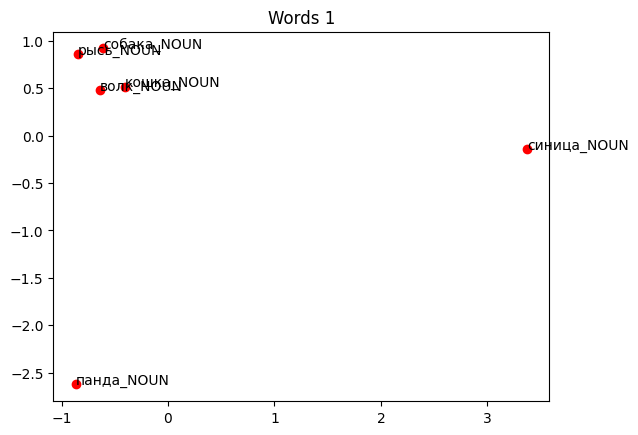

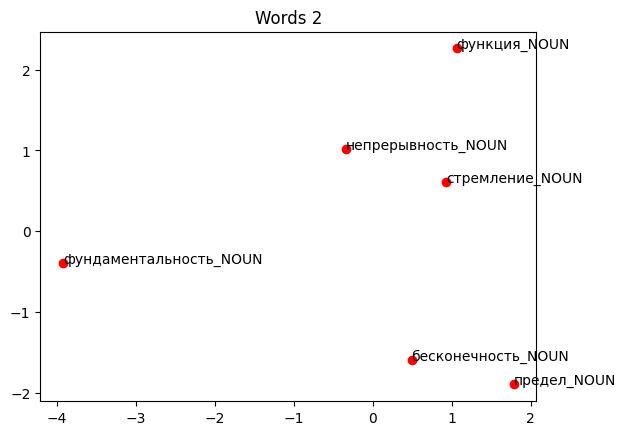

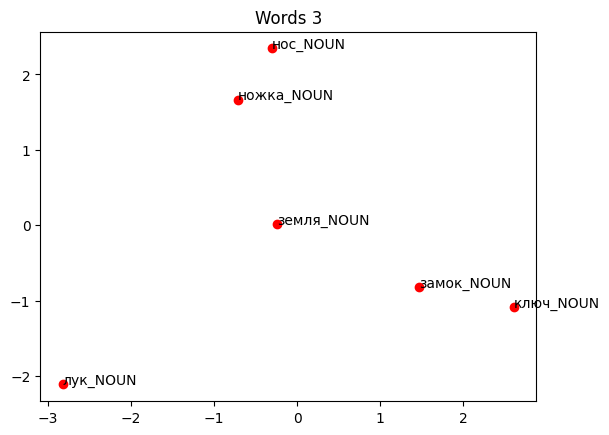

In [39]:
pca_maker(words1, 1)
pca_maker(words2, 2)
pca_maker(words3, 3)

**Words1**  
С животными справился отлично!

**Words2**
Всякие страшные штуки с матана.
Верно, но ожидалось, что фундаментальность будет ближе к остальным словам.

**Words3**
Что-то простое бытовое, но при этом многозначное.
Ну вроде норм


#### 4. Переписывание предложения

**Было:** Представьте себе, любезные читатели, человека полного, высокого, с лицом, похожим несколько лицо Крылова, с ясным и умным взором, с важной осанкой, мерной речью, медлительной походкой: вот вам Овсяников.  

**Стало:** Представляете себе, любезнейшие читательницы, человека полного, высокого, с лицами непохожими на два-три лица Крылова, с понятным и неглупым взором, с значимой выправкой, равномерной речью, неповоротливой походочкой: вот васильевич Овсяников

Смыслу стало плохо. Почему то самое близкое слово к "вы" - "васильевич".
Некоторые прилагателные использованы неправильно по отношению к определяемому.

Почему так? - потому что у модели нет контекста.


In [40]:
my_lem = "представить_VERB себя_PRON любезный_ADJ читатель_NOUN человек_NOUN полный_ADJ высокий_ADJ лицо_NOUN похожий_ADJ несколько_NUM лицо_NOUN ясный_ADJ умный_ADJ взор_NOUN важный_ADJ осанка_NOUN мерный_ADJ речь_NOUN медлительный_ADJ походка_NOUN вы_PRON"

In [41]:
def make_sim_sem(words):
    words_l = words.split(" ")
    ans = []
    for w in words_l:
        w_spl = w.split("_")[0]
        w_pos = w.split("_")[-1]
        for w_sim in model.most_similar(w):
            w_sim_spl = w_sim[0].split("_")[0]
            w_sim_pos = w_sim[0].split("_")[-1]
            w_sim_spl = w_sim_spl.replace("-", "")
            if w_spl != w_sim_spl and w_sim_pos == w_pos:
                ans.append(w_sim_spl)
                break
    return ans

print(make_sim_sem(my_lem))

['представлять', 'себе', 'любезнейший', 'читательница', 'людь', 'полнейший', 'низкий', 'лица', 'непохожий', 'дватри', 'лица', 'понятный', 'неглупый', 'взоромя', 'значимый', 'выправка', 'равномерный', 'речи', 'неповоротливый', 'походочка', 'васильевич']


### 3.2 TF-IDF

#### 1. Википедия

Честно не понимаю зачем получать статьи, сохранять в список потом в файлы, если в итоге я все беру из списка...  

Всего 24 статьи на 6 разных тематик. Первое слово в статье - всегда название статьи.(Это сделано чтобы потом воспользоваться костылём)0)0)

In [45]:
def get_wikipage(page):
    # print(page)
    time.sleep(1)
    return wiki.page(page).content

wiki.set_lang('ru') # Что-то рандомное что в голову пришло. Запускать осторожно, работает ужасно медленно!!
req = ["Алкены", "Автохимия", "Водород", "Ингибитор",
       "Математика", "Геометрия", "Сложение", "Граф (математика)",
       "Пуэрто-Рико", "Чернобыль", "Сидней", "Чанша",
       "Чили", "Таиланд", "Норвегия", "Замбия",
       "Перестройка", "Земщина", "Классицизм", "Революция",
       "Идо", "Токипона", "Сольресоль", "Ифкуиль"]
artcs = [get_wikipage(r) for r in req]

articles_preprocessed = []
for a_text in artcs:
    a_tokens = wordpunct_tokenize(a_text)
    a_lemmatized = " ".join([morph.parse(item)[0].normal_form for item in a_tokens])
    articles_preprocessed.append(a_lemmatized)

for n, page in enumerate(articles_preprocessed):
    with open(f"wiki/wiki_{n}.txt", "w", encoding='utf-8') as f:
        f.write(page)

#### 2. Строим TF-IDF

In [46]:
stops = stopwords.words("russian")

tfidf = TfidfVectorizer(
    analyzer="word", 
    stop_words=stops,
    ngram_range=(1,3),
    min_df=3
)

In [47]:
arc_tfidf = tfidf.fit_transform(articles_preprocessed)
feature = tfidf.get_feature_names_out()

#### 3. Смотрим на ключевые слова

In [48]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    """
    Вытаскивает ключевые слова
    """
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

In [49]:
for i, article in enumerate(artcs):
    article_vector = arc_tfidf[i, :]
    words = get_top_tf_idf_words(article_vector, feature, 10)
    print("Статья:", article.split(" ")[0], "\n", "Ключевые слова:", *words) # f-строки не поддерживают starred expression :(


Статья: Алке́ны 
 Ключевые слова: реакция ch rightarrow displaystyle двойной присоединение катализатор связь химия метод
Статья: Автоно́мия 
 Ключевые слова: автономия право университет автономный греческий собственный церковь корпорация самоуправление государство
Статья: Водоро́д 
 Ключевые слова: водород displaystyle газ металл температура химический вода вещество смесь воздух
Статья: Ингиби́торы 
 Ключевые слова: реакция металл вещество активный концентрация катализатор окисление поверхность соединение химический
Статья: Матема́тика 
 Ключевые слова: математика математический математик теория геометрия объект число наука алгебра свойство
Статья: Геоме́трия 
 Ключевые слова: геометрия точка прямой плоскость преобразование лежать фигура геометрический метод свойство
Статья: Сложе́ние 
 Ключевые слова: displaystyle операция число сумма quad 10 множество перенос натуральный это
Статья: Граф 
 Ключевые слова: displaystyle граф вершина множество quad in элемент цикл называться пара
Статья

В ключевых словах встречаются какие-то странные "displaystyle". Смотрее всего проблемы библиотеки википедии.

Ну ожиданиям соответсвует ураура! Ничего сверхъественного не наблюдается.  
В статьях с тематикой города, страны и истоиря часто встречается слово "год".  


Иногда ключевое слово это и есть название статьи

#### 4. Визуализация TF-IDF текстов

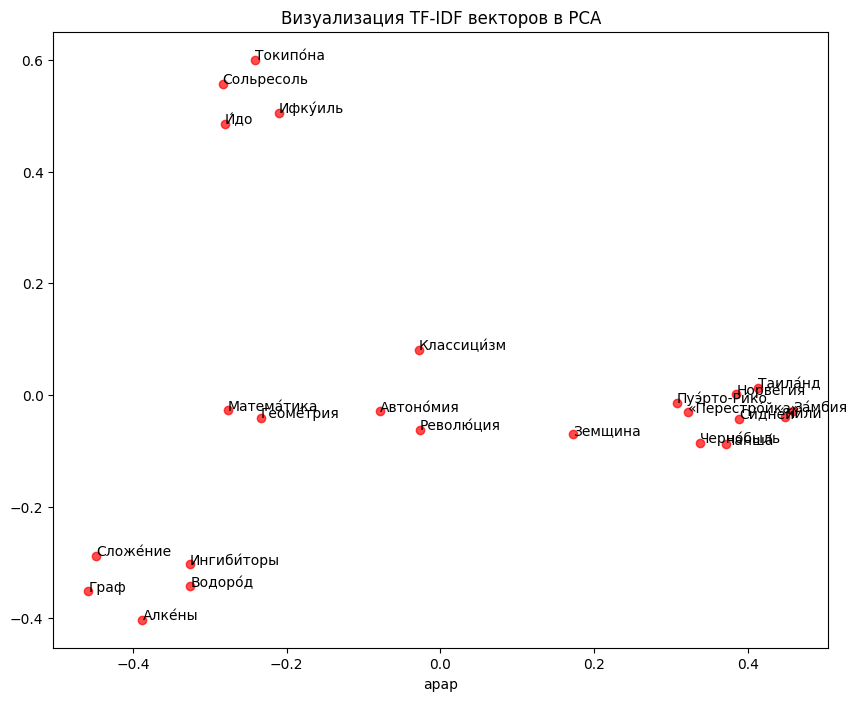

In [ ]:
pca = PCA(n_components=2)
pca_arc = pca.fit_transform(arc_tfidf.toarray())
labels = [article.split()[0]  for article in artcs]

plt.figure(figsize=(10, 8))
plt.scatter(pca_arc[:, 0], pca_arc[:, 1], c='red', alpha=0.7)

for i, (x, y) in enumerate(pca_arc):
    plt.text(x, y, labels[i])

plt.title("Визуализация TF-IDF векторов в PCA")
plt.show()


Сложение потерялось среди химии, "перестройка" спряталась с городами. Хотя это логично, ведь в "перестройке" много что про здания и постройки..?
Статьи,вязанные с историей немножко плавают.  

Остальное норм. Действительно, схожая тематика -> близкое расположение! Но скорее потому что схожая тематика -> схожая лексика -> близкое расположение

### 4. TF-IDF

#### 1. token_pattern

Судя по документации, оно принимает регулярку, которая применяется к токенам

In [51]:
stops = stopwords.words("russian")

tfidf2 = TfidfVectorizer(
    analyzer="word", # анализировать по словам или по символам (char)
    stop_words=stops, # передаём список стоп-слов для русского из NLTK
    ngram_range=(1,3),
    min_df=3,
    token_pattern=r"\D+"
)

arc_tfidf2 = tfidf2.fit_transform(articles_preprocessed)


#### 2. Cosine_similarity

In [ ]:
cosine_sim = cosine_similarity(arc_tfidf2, arc_tfidf2)

In [ ]:
cosine_sim # Полный пупупу...

In [67]:
len(cosine_sim[0])

24

In [86]:
labels = [article.split()[0]  for article in artcs]
for i in range(len(cosine_sim)):
    print(f"Для статьи {labels[i]} самая близкая {labels[np.argsort(cosine_sim[i], axis=0)[-2]]}")


Для статьи Алке́ны самая близкая Водоро́д
Для статьи Автоно́мия самая близкая Геоме́трия
Для статьи Водоро́д самая близкая Алке́ны
Для статьи Ингиби́торы самая близкая Револю́ция
Для статьи Матема́тика самая близкая Норве́гия
Для статьи Геоме́трия самая близкая Автоно́мия
Для статьи Сложе́ние самая близкая Норве́гия
Для статьи Граф самая близкая Ифку́иль
Для статьи Пуэ́рто-Ри́ко самая близкая Норве́гия
Для статьи Черно́быль самая близкая «Перестро́йка»
Для статьи Си́дне́й самая близкая Чи́ли
Для статьи Чанша́ самая близкая Пуэ́рто-Ри́ко
Для статьи Чи́ли самая близкая Си́дне́й
Для статьи Таила́нд самая близкая Чи́ли
Для статьи Норве́гия самая близкая Пуэ́рто-Ри́ко
Для статьи За́мбия самая близкая Таила́нд
Для статьи «Перестро́йка» самая близкая Черно́быль
Для статьи Земщина самая близкая Ингиби́торы
Для статьи Классици́зм самая близкая Револю́ция
Для статьи Револю́ция самая близкая Классици́зм
Для статьи И́до самая близкая Норве́гия
Для статьи Токипо́на самая близкая Граф
Для статьи Сол

####  3. Cluster map

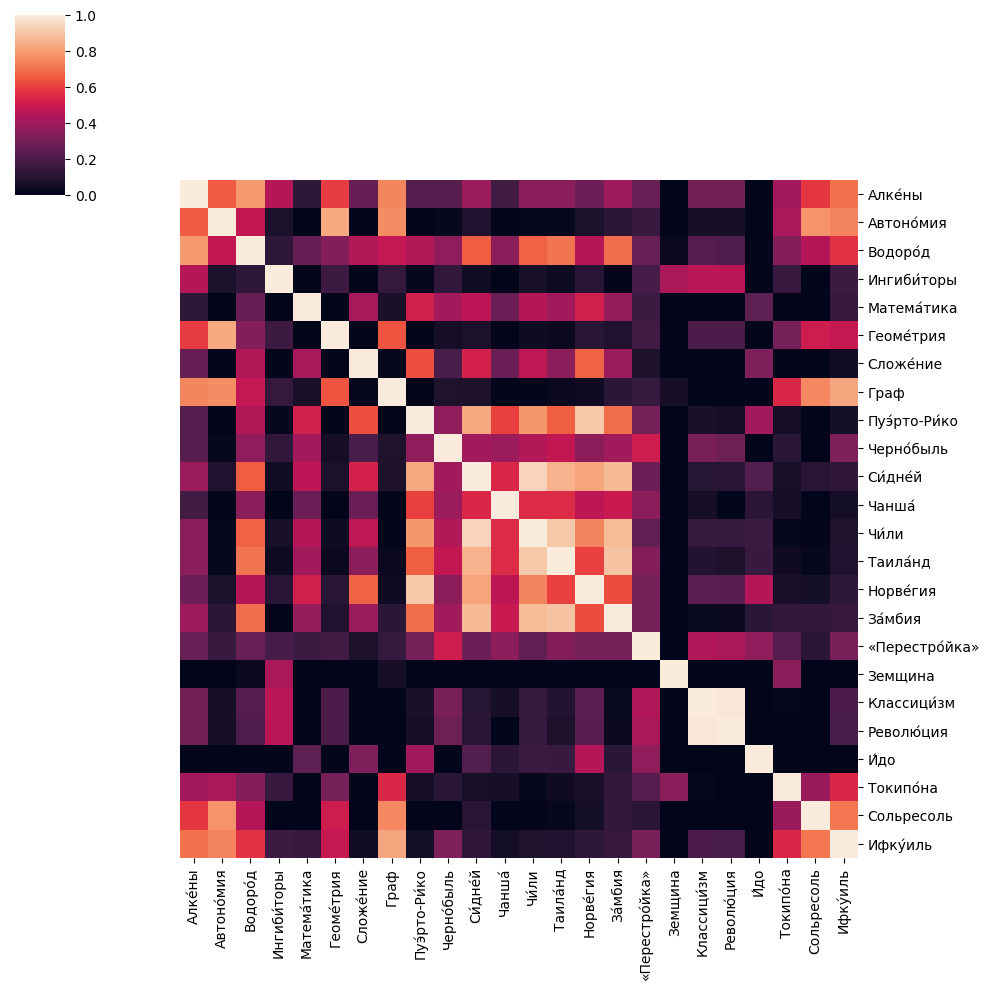

In [ ]:
sns.clustermap(cosine_sim,
    xticklabels=labels,
    yticklabels=labels,
    row_cluster=False,
    col_cluster=False,)

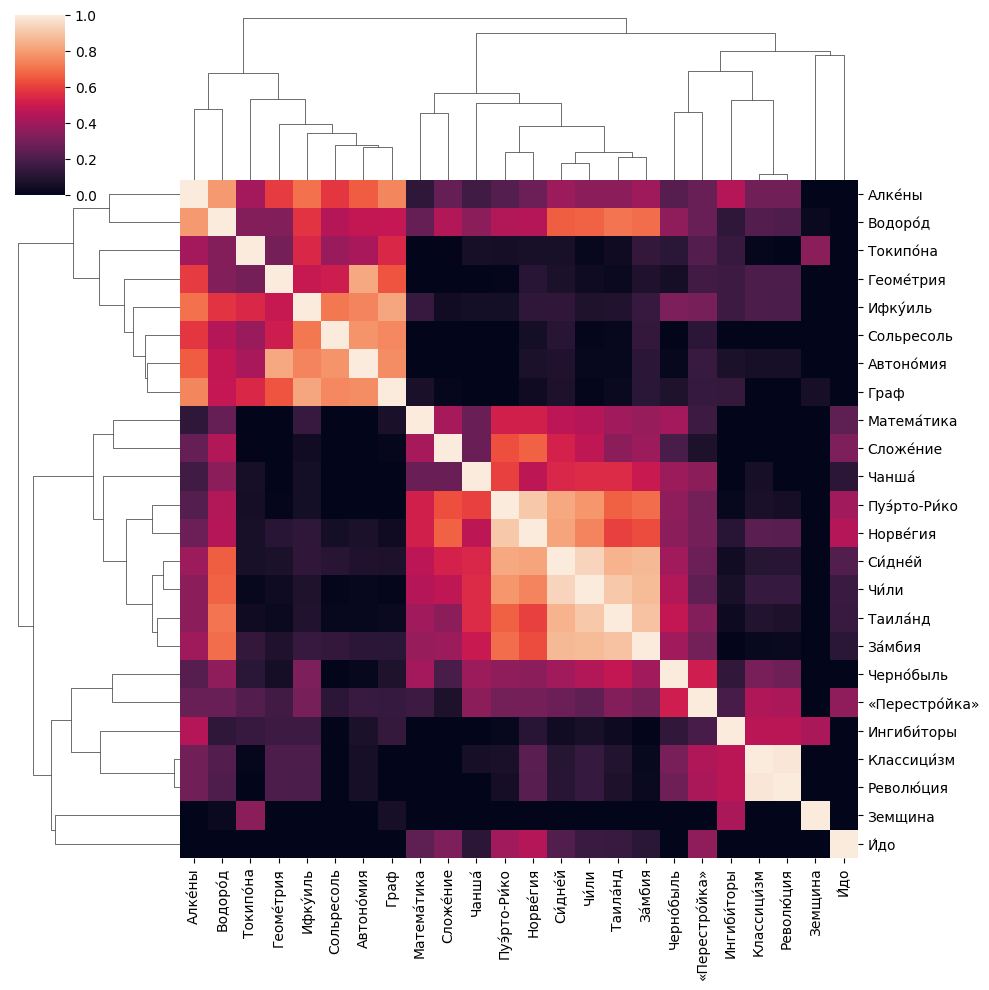

In [89]:
sns.clustermap(cosine_sim,
    xticklabels=labels,
    yticklabels=labels,)

В целом норм, диагональки самые светлые - тк это и есть расстояние до самого слова, то есть максимальное. На неупорядоченной карте хорошо видно, что города и страны близки.
Также есть маленькие квадратики подгруппы искусственных языков и химических штук. Почему-то алкены и водрод хорошо дружат с городами и странами...

+